In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

## **Seasonal Decomposition**

In [2]:
# Training data
train_data = pd.read_csv("cleaned_data/train_clean.csv", parse_dates=['date'], index_col=['date'])
# Frequency
train_data = train_data.asfreq('D')

tseries = train_data['meantemp']

In [3]:
tseries_log = np.log(tseries)
[tseries_box_cox_auto, opt_lambda] = stats.boxcox(tseries)

<Axes: xlabel='date'>

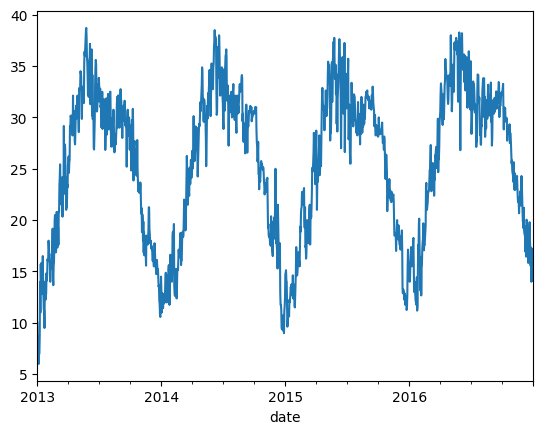

In [4]:
tseries.plot()

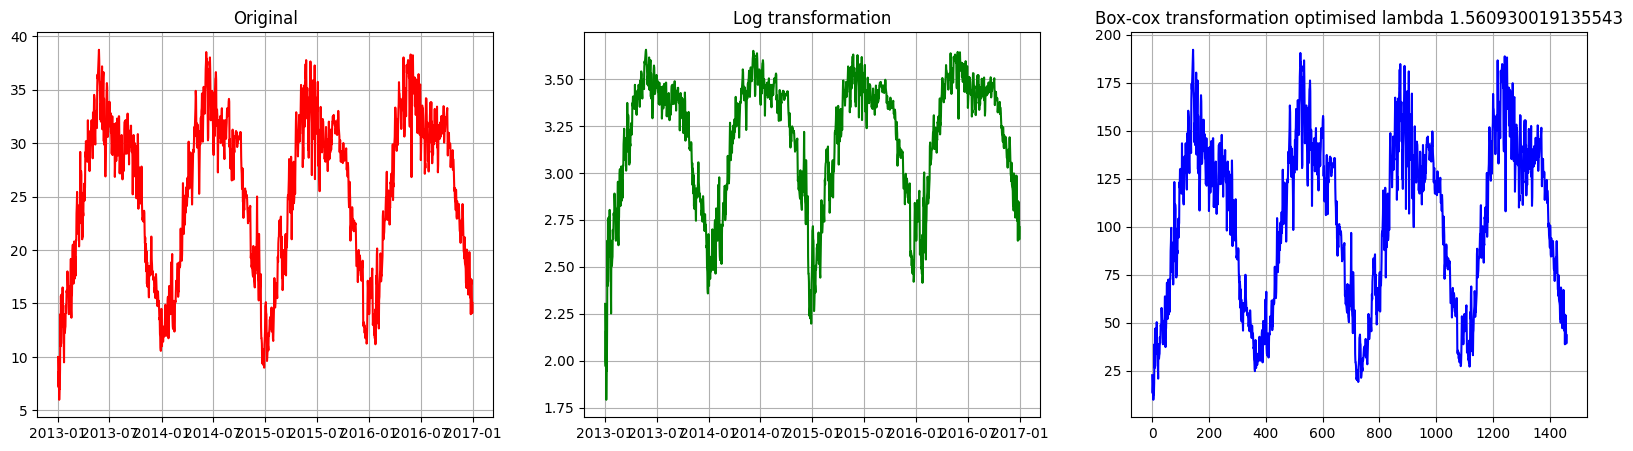

In [5]:
# Visualization of the results
fig,axes = plt.subplots(1,3,figsize=(20,5))
axes[0].grid()
axes[0].plot(tseries,color='red')
axes[0].set_title('Original')

axes[1].plot(tseries_log,color='green')
axes[1].grid()
axes[1].set_title('Log transformation')

axes[2].plot(tseries_box_cox_auto,color='blue')
axes[2].grid()
axes[2].set_title('Box-cox transformation optimised lambda '+str(opt_lambda))

plt.show()

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

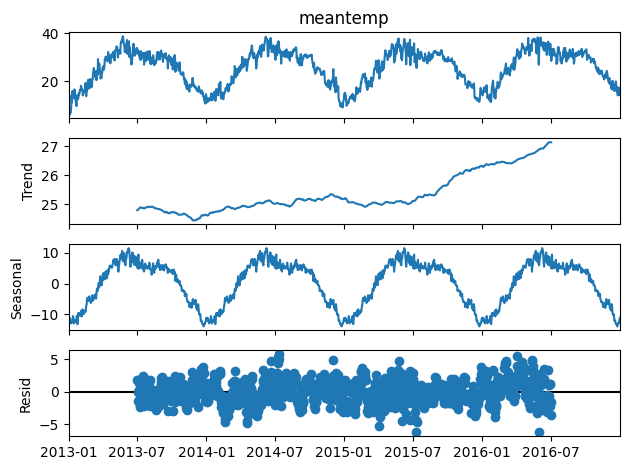

In [28]:
decompose_data_additive = seasonal_decompose(tseries, model='additive', period=365)

decompose_data_additive.plot()
plt.show()

In [29]:
decompose_data_trend = decompose_data_additive.trend
seasonal_adjusted = tseries - decompose_data_additive.seasonal


<Axes: xlabel='date'>

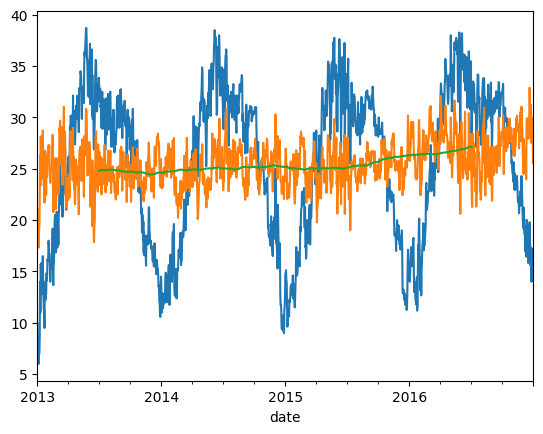

In [31]:
tseries.plot()
seasonal_adjusted.plot()
decompose_data_trend.plot()

In [34]:
from scipy import stats,signal

# FFT and Amplitude Spectrum
signal_meantemp = train_data['meantemp']
Fs = 1 # sampling frequency, our unit of measure is "months" (Important!)


Frequency for the maximum value is:  0.01916495550992471
Period (months/cycle):  52.17857142857142


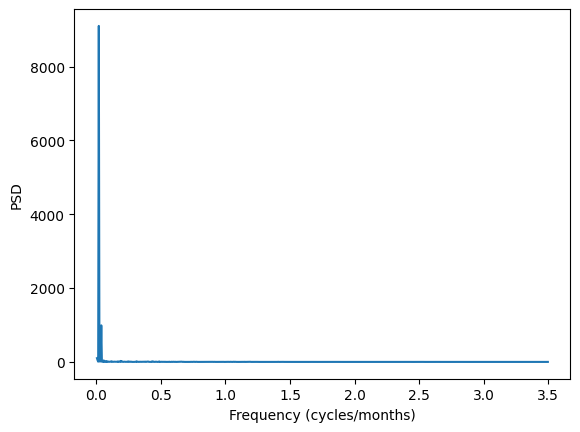

In [33]:
# PSD using the raw periodogram
f_per, Pxx_per = signal.periodogram(signal_meantemp,Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

plt.plot(f_per, Pxx_per)
plt.xlabel('Frequency (cycles/months)')
plt.ylabel('PSD');
temp = np.where(Pxx_per == Pxx_per.max())
print('Frequency for the maximum value is: ',float(f_per[temp]))
print('Period (months/cycle): ',float(1/f_per[temp]))